<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[04:10:10] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


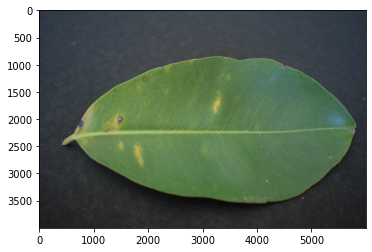

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

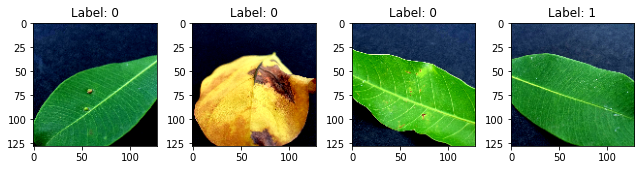

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[04:10:18] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[04:10:20] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.254860474206543 samples/sec                   batch loss = 1.11605966091156 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2590147242866794 samples/sec                   batch loss = 0.8006641268730164 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.263607671326146 samples/sec                   batch loss = 0.7371168732643127 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.2645615283382652 samples/sec                   batch loss = 0.9871234893798828 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.2571612948572146 samples/sec                   batch loss = 0.6752474904060364 | accuracy = 0.52


Epoch[1] Batch[30] Speed: 1.2610026078073073 samples/sec                   batch loss = 0.582382321357727 | accuracy = 0.5166666666666667


Epoch[1] Batch[35] Speed: 1.2657572374209969 samples/sec                   batch loss = 0.8251234292984009 | accuracy = 0.5142857142857142


Epoch[1] Batch[40] Speed: 1.2636137622992127 samples/sec                   batch loss = 0.6291569471359253 | accuracy = 0.5125


Epoch[1] Batch[45] Speed: 1.2677940772857028 samples/sec                   batch loss = 0.6683833003044128 | accuracy = 0.5222222222222223


Epoch[1] Batch[50] Speed: 1.261544028199511 samples/sec                   batch loss = 0.6606606841087341 | accuracy = 0.52


Epoch[1] Batch[55] Speed: 1.2636511659681287 samples/sec                   batch loss = 1.0798277854919434 | accuracy = 0.5409090909090909


Epoch[1] Batch[60] Speed: 1.2584888771403768 samples/sec                   batch loss = 1.0985013246536255 | accuracy = 0.5583333333333333


Epoch[1] Batch[65] Speed: 1.2636173788422547 samples/sec                   batch loss = 0.2936432361602783 | accuracy = 0.5653846153846154


Epoch[1] Batch[70] Speed: 1.2638911541339 samples/sec                   batch loss = 0.43659111857414246 | accuracy = 0.5678571428571428


Epoch[1] Batch[75] Speed: 1.2629894576329217 samples/sec                   batch loss = 0.6190943717956543 | accuracy = 0.5833333333333334


Epoch[1] Batch[80] Speed: 1.263907626319074 samples/sec                   batch loss = 0.9240461587905884 | accuracy = 0.58125


Epoch[1] Batch[85] Speed: 1.2646043261016566 samples/sec                   batch loss = 0.7003028392791748 | accuracy = 0.5911764705882353


Epoch[1] Batch[90] Speed: 1.2644193347477886 samples/sec                   batch loss = 0.6370265483856201 | accuracy = 0.5861111111111111


Epoch[1] Batch[95] Speed: 1.262323882992803 samples/sec                   batch loss = 0.8357482552528381 | accuracy = 0.5842105263157895


Epoch[1] Batch[100] Speed: 1.273725634056967 samples/sec                   batch loss = 0.41147661209106445 | accuracy = 0.5925


Epoch[1] Batch[105] Speed: 1.2641660958891208 samples/sec                   batch loss = 1.2114378213882446 | accuracy = 0.5880952380952381


Epoch[1] Batch[110] Speed: 1.260896938089833 samples/sec                   batch loss = 0.6023987531661987 | accuracy = 0.5931818181818181


Epoch[1] Batch[115] Speed: 1.2665230934985028 samples/sec                   batch loss = 0.8141291737556458 | accuracy = 0.591304347826087


Epoch[1] Batch[120] Speed: 1.2640344670042807 samples/sec                   batch loss = 0.6272399425506592 | accuracy = 0.5916666666666667


Epoch[1] Batch[125] Speed: 1.259760900054048 samples/sec                   batch loss = 0.5990612506866455 | accuracy = 0.602


Epoch[1] Batch[130] Speed: 1.2640214199033835 samples/sec                   batch loss = 0.5532139539718628 | accuracy = 0.6019230769230769


Epoch[1] Batch[135] Speed: 1.2635528552108477 samples/sec                   batch loss = 0.6723439693450928 | accuracy = 0.6018518518518519


Epoch[1] Batch[140] Speed: 1.2656402667730444 samples/sec                   batch loss = 0.6870523691177368 | accuracy = 0.5982142857142857


Epoch[1] Batch[145] Speed: 1.2569246087191701 samples/sec                   batch loss = 0.6922908425331116 | accuracy = 0.6


Epoch[1] Batch[150] Speed: 1.265341111268488 samples/sec                   batch loss = 0.48697125911712646 | accuracy = 0.6066666666666667


Epoch[1] Batch[155] Speed: 1.2577366639048844 samples/sec                   batch loss = 0.8990235328674316 | accuracy = 0.6064516129032258


Epoch[1] Batch[160] Speed: 1.2648230307157984 samples/sec                   batch loss = 0.4776286482810974 | accuracy = 0.60625


Epoch[1] Batch[165] Speed: 1.2654292968491314 samples/sec                   batch loss = 0.741724967956543 | accuracy = 0.6


Epoch[1] Batch[170] Speed: 1.2577940883314391 samples/sec                   batch loss = 0.617224931716919 | accuracy = 0.6014705882352941


Epoch[1] Batch[175] Speed: 1.2649322206516431 samples/sec                   batch loss = 0.459061861038208 | accuracy = 0.61


Epoch[1] Batch[180] Speed: 1.267273890792717 samples/sec                   batch loss = 0.34770718216896057 | accuracy = 0.6152777777777778


Epoch[1] Batch[185] Speed: 1.2584176080487286 samples/sec                   batch loss = 0.9734832644462585 | accuracy = 0.6121621621621621


Epoch[1] Batch[190] Speed: 1.2665644942689016 samples/sec                   batch loss = 0.7510358691215515 | accuracy = 0.6078947368421053


Epoch[1] Batch[195] Speed: 1.2676001065927882 samples/sec                   batch loss = 0.31275826692581177 | accuracy = 0.6141025641025641


Epoch[1] Batch[200] Speed: 1.2646313025723162 samples/sec                   batch loss = 0.4934416115283966 | accuracy = 0.62


Epoch[1] Batch[205] Speed: 1.2618532540043976 samples/sec                   batch loss = 0.6274312138557434 | accuracy = 0.6207317073170732


Epoch[1] Batch[210] Speed: 1.261574858581287 samples/sec                   batch loss = 0.8047425150871277 | accuracy = 0.6226190476190476


Epoch[1] Batch[215] Speed: 1.255959949938921 samples/sec                   batch loss = 0.6831772327423096 | accuracy = 0.6244186046511628


Epoch[1] Batch[220] Speed: 1.2623808721925986 samples/sec                   batch loss = 0.46285557746887207 | accuracy = 0.6284090909090909


Epoch[1] Batch[225] Speed: 1.2567383740650053 samples/sec                   batch loss = 0.4698326885700226 | accuracy = 0.6344444444444445


Epoch[1] Batch[230] Speed: 1.2601206431497247 samples/sec                   batch loss = 0.5740281939506531 | accuracy = 0.6326086956521739


Epoch[1] Batch[235] Speed: 1.2604102331943021 samples/sec                   batch loss = 0.6637440323829651 | accuracy = 0.6361702127659574


Epoch[1] Batch[240] Speed: 1.2560681791348627 samples/sec                   batch loss = 0.37091925740242004 | accuracy = 0.6395833333333333


Epoch[1] Batch[245] Speed: 1.260634120027925 samples/sec                   batch loss = 0.531204104423523 | accuracy = 0.6428571428571429


Epoch[1] Batch[250] Speed: 1.2601957022599328 samples/sec                   batch loss = 0.3859111964702606 | accuracy = 0.648


Epoch[1] Batch[255] Speed: 1.2568549290298512 samples/sec                   batch loss = 0.8031589388847351 | accuracy = 0.65


Epoch[1] Batch[260] Speed: 1.261338973361333 samples/sec                   batch loss = 0.3550644516944885 | accuracy = 0.6519230769230769


Epoch[1] Batch[265] Speed: 1.2581612004939589 samples/sec                   batch loss = 0.35322514176368713 | accuracy = 0.6575471698113208


Epoch[1] Batch[270] Speed: 1.2607468511980924 samples/sec                   batch loss = 0.5539951920509338 | accuracy = 0.6592592592592592


Epoch[1] Batch[275] Speed: 1.260256096786903 samples/sec                   batch loss = 0.8423303365707397 | accuracy = 0.6627272727272727


Epoch[1] Batch[280] Speed: 1.2620828755831144 samples/sec                   batch loss = 0.19660183787345886 | accuracy = 0.6642857142857143


Epoch[1] Batch[285] Speed: 1.2588334425053591 samples/sec                   batch loss = 0.503274142742157 | accuracy = 0.6666666666666666


Epoch[1] Batch[290] Speed: 1.2585676129119858 samples/sec                   batch loss = 0.633019745349884 | accuracy = 0.6681034482758621


Epoch[1] Batch[295] Speed: 1.2579313058533954 samples/sec                   batch loss = 0.47680172324180603 | accuracy = 0.6669491525423729


Epoch[1] Batch[300] Speed: 1.2581465760510828 samples/sec                   batch loss = 0.20203246176242828 | accuracy = 0.6691666666666667


Epoch[1] Batch[305] Speed: 1.264331099311074 samples/sec                   batch loss = 0.4322860538959503 | accuracy = 0.6688524590163935


Epoch[1] Batch[310] Speed: 1.2609374032344278 samples/sec                   batch loss = 0.5999398231506348 | accuracy = 0.6693548387096774


Epoch[1] Batch[315] Speed: 1.2689632763261487 samples/sec                   batch loss = 0.45196112990379333 | accuracy = 0.6706349206349206


Epoch[1] Batch[320] Speed: 1.2538336645931631 samples/sec                   batch loss = 1.0480750799179077 | accuracy = 0.66953125


Epoch[1] Batch[325] Speed: 1.2611424223169347 samples/sec                   batch loss = 0.29393279552459717 | accuracy = 0.6707692307692308


Epoch[1] Batch[330] Speed: 1.2597637378331532 samples/sec                   batch loss = 1.1035908460617065 | accuracy = 0.671969696969697


Epoch[1] Batch[335] Speed: 1.2571685484862019 samples/sec                   batch loss = 0.1347775161266327 | accuracy = 0.6723880597014925


Epoch[1] Batch[340] Speed: 1.2625102567760944 samples/sec                   batch loss = 0.5081011056900024 | accuracy = 0.6735294117647059


Epoch[1] Batch[345] Speed: 1.2584419613469693 samples/sec                   batch loss = 0.49813687801361084 | accuracy = 0.6731884057971015


Epoch[1] Batch[350] Speed: 1.2624351116932553 samples/sec                   batch loss = 0.48088982701301575 | accuracy = 0.6742857142857143


Epoch[1] Batch[355] Speed: 1.258863479337707 samples/sec                   batch loss = 0.6206159591674805 | accuracy = 0.673943661971831


Epoch[1] Batch[360] Speed: 1.257258896151842 samples/sec                   batch loss = 0.7358419895172119 | accuracy = 0.6722222222222223


Epoch[1] Batch[365] Speed: 1.260755188421371 samples/sec                   batch loss = 0.6021973490715027 | accuracy = 0.6726027397260274


Epoch[1] Batch[370] Speed: 1.2551707513742771 samples/sec                   batch loss = 0.406947523355484 | accuracy = 0.675


Epoch[1] Batch[375] Speed: 1.260947069765694 samples/sec                   batch loss = 0.6649702787399292 | accuracy = 0.6733333333333333


Epoch[1] Batch[380] Speed: 1.2624974311288562 samples/sec                   batch loss = 0.42373594641685486 | accuracy = 0.6763157894736842


Epoch[1] Batch[385] Speed: 1.2634067021518454 samples/sec                   batch loss = 0.8040493130683899 | accuracy = 0.6766233766233766


Epoch[1] Batch[390] Speed: 1.2616174544185745 samples/sec                   batch loss = 0.6363276839256287 | accuracy = 0.6756410256410257


Epoch[1] Batch[395] Speed: 1.2708523683514037 samples/sec                   batch loss = 0.6564581990242004 | accuracy = 0.6746835443037975


Epoch[1] Batch[400] Speed: 1.2650849274502702 samples/sec                   batch loss = 0.39687642455101013 | accuracy = 0.67625


Epoch[1] Batch[405] Speed: 1.261925767046102 samples/sec                   batch loss = 0.6421728134155273 | accuracy = 0.6753086419753086


Epoch[1] Batch[410] Speed: 1.262334710544817 samples/sec                   batch loss = 0.47735652327537537 | accuracy = 0.676219512195122


Epoch[1] Batch[415] Speed: 1.260595568699583 samples/sec                   batch loss = 0.3810623586177826 | accuracy = 0.6759036144578313


Epoch[1] Batch[420] Speed: 1.2596250799784432 samples/sec                   batch loss = 0.6232039928436279 | accuracy = 0.6767857142857143


Epoch[1] Batch[425] Speed: 1.2690440961616998 samples/sec                   batch loss = 0.5784946084022522 | accuracy = 0.6758823529411765


Epoch[1] Batch[430] Speed: 1.2689805528605624 samples/sec                   batch loss = 0.8540077805519104 | accuracy = 0.6773255813953488


Epoch[1] Batch[435] Speed: 1.2665816099277822 samples/sec                   batch loss = 0.6112474203109741 | accuracy = 0.6787356321839081


Epoch[1] Batch[440] Speed: 1.2559206497735524 samples/sec                   batch loss = 0.5882286429405212 | accuracy = 0.6795454545454546


Epoch[1] Batch[445] Speed: 1.267321371701925 samples/sec                   batch loss = 0.32769864797592163 | accuracy = 0.6808988764044944


Epoch[1] Batch[450] Speed: 1.2665149666442888 samples/sec                   batch loss = 0.353526771068573 | accuracy = 0.6805555555555556


Epoch[1] Batch[455] Speed: 1.2667790949785167 samples/sec                   batch loss = 0.3688925802707672 | accuracy = 0.6813186813186813


Epoch[1] Batch[460] Speed: 1.2652722129074958 samples/sec                   batch loss = 1.0052332878112793 | accuracy = 0.6809782608695653


Epoch[1] Batch[465] Speed: 1.2578794331675527 samples/sec                   batch loss = 0.9480289816856384 | accuracy = 0.6811827956989247


Epoch[1] Batch[470] Speed: 1.2643741673377704 samples/sec                   batch loss = 0.2816966772079468 | accuracy = 0.6819148936170213


Epoch[1] Batch[475] Speed: 1.2667159695741415 samples/sec                   batch loss = 0.5447498559951782 | accuracy = 0.6815789473684211


Epoch[1] Batch[480] Speed: 1.2638262217250114 samples/sec                   batch loss = 0.34630346298217773 | accuracy = 0.6822916666666666


Epoch[1] Batch[485] Speed: 1.2599264585505527 samples/sec                   batch loss = 0.6586179733276367 | accuracy = 0.6824742268041237


Epoch[1] Batch[490] Speed: 1.266275701435401 samples/sec                   batch loss = 0.6165652275085449 | accuracy = 0.6821428571428572


Epoch[1] Batch[495] Speed: 1.266187684530498 samples/sec                   batch loss = 0.4310390055179596 | accuracy = 0.6833333333333333


Epoch[1] Batch[500] Speed: 1.2686250389800195 samples/sec                   batch loss = 0.8380005955696106 | accuracy = 0.682


Epoch[1] Batch[505] Speed: 1.2665684145745066 samples/sec                   batch loss = 0.29853421449661255 | accuracy = 0.6821782178217822


Epoch[1] Batch[510] Speed: 1.2625100667646039 samples/sec                   batch loss = 0.5586748123168945 | accuracy = 0.6823529411764706


Epoch[1] Batch[515] Speed: 1.2583867430134632 samples/sec                   batch loss = 0.7820279002189636 | accuracy = 0.6815533980582524


Epoch[1] Batch[520] Speed: 1.2616350058787058 samples/sec                   batch loss = 0.6298869848251343 | accuracy = 0.6802884615384616


Epoch[1] Batch[525] Speed: 1.2618499322714887 samples/sec                   batch loss = 0.37108558416366577 | accuracy = 0.679047619047619


Epoch[1] Batch[530] Speed: 1.2679011937026092 samples/sec                   batch loss = 0.4507954716682434 | accuracy = 0.6806603773584906


Epoch[1] Batch[535] Speed: 1.2657241014998528 samples/sec                   batch loss = 0.3339930772781372 | accuracy = 0.680841121495327


Epoch[1] Batch[540] Speed: 1.2634612201397508 samples/sec                   batch loss = 1.077575922012329 | accuracy = 0.6810185185185185


Epoch[1] Batch[545] Speed: 1.2614571420622909 samples/sec                   batch loss = 0.40187719464302063 | accuracy = 0.6839449541284404


Epoch[1] Batch[550] Speed: 1.2616400342248446 samples/sec                   batch loss = 0.4572146534919739 | accuracy = 0.6845454545454546


Epoch[1] Batch[555] Speed: 1.260682336187046 samples/sec                   batch loss = 0.6878777146339417 | accuracy = 0.6833333333333333


Epoch[1] Batch[560] Speed: 1.2592398168350172 samples/sec                   batch loss = 0.5649715662002563 | accuracy = 0.6839285714285714


Epoch[1] Batch[565] Speed: 1.260220313750782 samples/sec                   batch loss = 0.2491539716720581 | accuracy = 0.6858407079646017


Epoch[1] Batch[570] Speed: 1.259006032149904 samples/sec                   batch loss = 0.4742681086063385 | accuracy = 0.6864035087719298


Epoch[1] Batch[575] Speed: 1.269889577721926 samples/sec                   batch loss = 1.122183084487915 | accuracy = 0.6865217391304348


Epoch[1] Batch[580] Speed: 1.2582226268668357 samples/sec                   batch loss = 0.47010093927383423 | accuracy = 0.6853448275862069


Epoch[1] Batch[585] Speed: 1.2566440538064731 samples/sec                   batch loss = 0.4006614685058594 | accuracy = 0.6863247863247863


Epoch[1] Batch[590] Speed: 1.2588992798246372 samples/sec                   batch loss = 0.5232429504394531 | accuracy = 0.6847457627118644


Epoch[1] Batch[595] Speed: 1.2605240608082142 samples/sec                   batch loss = 0.25954729318618774 | accuracy = 0.684453781512605


Epoch[1] Batch[600] Speed: 1.2617156539994112 samples/sec                   batch loss = 1.2305268049240112 | accuracy = 0.6833333333333333


Epoch[1] Batch[605] Speed: 1.2600590313194655 samples/sec                   batch loss = 0.5141808390617371 | accuracy = 0.6818181818181818


Epoch[1] Batch[610] Speed: 1.2613013271497762 samples/sec                   batch loss = 0.4408811926841736 | accuracy = 0.6815573770491803


Epoch[1] Batch[615] Speed: 1.2593460597432924 samples/sec                   batch loss = 0.46634697914123535 | accuracy = 0.6821138211382114


Epoch[1] Batch[620] Speed: 1.2610336960822397 samples/sec                   batch loss = 0.5252526998519897 | accuracy = 0.6806451612903226


Epoch[1] Batch[625] Speed: 1.259268833358778 samples/sec                   batch loss = 0.3959255814552307 | accuracy = 0.6816


Epoch[1] Batch[630] Speed: 1.2615286610027312 samples/sec                   batch loss = 0.5043744444847107 | accuracy = 0.6825396825396826


Epoch[1] Batch[635] Speed: 1.2585775263872532 samples/sec                   batch loss = 0.4718285799026489 | accuracy = 0.6830708661417323


Epoch[1] Batch[640] Speed: 1.2610009965665467 samples/sec                   batch loss = 0.783387303352356 | accuracy = 0.68359375


Epoch[1] Batch[645] Speed: 1.2624258972988331 samples/sec                   batch loss = 0.44933855533599854 | accuracy = 0.6844961240310078


Epoch[1] Batch[650] Speed: 1.257035358824766 samples/sec                   batch loss = 0.47489452362060547 | accuracy = 0.6834615384615385


Epoch[1] Batch[655] Speed: 1.2589308312821037 samples/sec                   batch loss = 0.671018660068512 | accuracy = 0.683969465648855


Epoch[1] Batch[660] Speed: 1.261100048137216 samples/sec                   batch loss = 0.4675526022911072 | accuracy = 0.6840909090909091


Epoch[1] Batch[665] Speed: 1.2573338031755719 samples/sec                   batch loss = 0.49482598900794983 | accuracy = 0.6830827067669173


Epoch[1] Batch[670] Speed: 1.2576569007421108 samples/sec                   batch loss = 0.17780496180057526 | accuracy = 0.6835820895522388


Epoch[1] Batch[675] Speed: 1.2576604832676412 samples/sec                   batch loss = 0.36833900213241577 | accuracy = 0.6851851851851852


Epoch[1] Batch[680] Speed: 1.2604706482861854 samples/sec                   batch loss = 0.9835628271102905 | accuracy = 0.6852941176470588


Epoch[1] Batch[685] Speed: 1.2607069666895705 samples/sec                   batch loss = 0.3492588698863983 | accuracy = 0.6854014598540146


Epoch[1] Batch[690] Speed: 1.2545029773592682 samples/sec                   batch loss = 0.553035318851471 | accuracy = 0.686231884057971


Epoch[1] Batch[695] Speed: 1.2624975261326925 samples/sec                   batch loss = 0.40560317039489746 | accuracy = 0.6863309352517986


Epoch[1] Batch[700] Speed: 1.254511513623392 samples/sec                   batch loss = 0.4471193253993988 | accuracy = 0.6860714285714286


Epoch[1] Batch[705] Speed: 1.2603969767389622 samples/sec                   batch loss = 0.5251075625419617 | accuracy = 0.6865248226950355


Epoch[1] Batch[710] Speed: 1.262664089842545 samples/sec                   batch loss = 0.506344735622406 | accuracy = 0.6862676056338028


Epoch[1] Batch[715] Speed: 1.2628482827418954 samples/sec                   batch loss = 0.20197667181491852 | accuracy = 0.6874125874125874


Epoch[1] Batch[720] Speed: 1.2591935065869826 samples/sec                   batch loss = 0.49639129638671875 | accuracy = 0.6892361111111112


Epoch[1] Batch[725] Speed: 1.2592995526342832 samples/sec                   batch loss = 0.7152334451675415 | accuracy = 0.6896551724137931


Epoch[1] Batch[730] Speed: 1.2564658064763512 samples/sec                   batch loss = 0.47209715843200684 | accuracy = 0.6893835616438356


Epoch[1] Batch[735] Speed: 1.2609663084993237 samples/sec                   batch loss = 0.7705919146537781 | accuracy = 0.6891156462585034


Epoch[1] Batch[740] Speed: 1.25639805940409 samples/sec                   batch loss = 0.26218611001968384 | accuracy = 0.6891891891891891


Epoch[1] Batch[745] Speed: 1.2618725204001477 samples/sec                   batch loss = 0.9995717406272888 | accuracy = 0.6895973154362416


Epoch[1] Batch[750] Speed: 1.2569328954665142 samples/sec                   batch loss = 1.1037988662719727 | accuracy = 0.6883333333333334


Epoch[1] Batch[755] Speed: 1.2591709197630925 samples/sec                   batch loss = 0.477263480424881 | accuracy = 0.6894039735099338


Epoch[1] Batch[760] Speed: 1.2634283946096123 samples/sec                   batch loss = 0.7833649516105652 | accuracy = 0.6884868421052631


Epoch[1] Batch[765] Speed: 1.258800668100397 samples/sec                   batch loss = 0.5053418278694153 | accuracy = 0.6901960784313725


Epoch[1] Batch[770] Speed: 1.2639188619286805 samples/sec                   batch loss = 0.6801756620407104 | accuracy = 0.6892857142857143


Epoch[1] Batch[775] Speed: 1.2608727739610466 samples/sec                   batch loss = 0.32008978724479675 | accuracy = 0.6896774193548387


Epoch[1] Batch[780] Speed: 1.2681589029436675 samples/sec                   batch loss = 0.4339481592178345 | accuracy = 0.6900641025641026


Epoch[1] Batch[785] Speed: 1.261803145148814 samples/sec                   batch loss = 1.0914279222488403 | accuracy = 0.6894904458598726


[Epoch 1] training: accuracy=0.6903553299492385
[Epoch 1] time cost: 651.8990669250488
[Epoch 1] validation: validation accuracy=0.7488888888888889


Epoch[2] Batch[5] Speed: 1.2601123143166504 samples/sec                   batch loss = 0.2897310256958008 | accuracy = 0.55


Epoch[2] Batch[10] Speed: 1.2601531077204846 samples/sec                   batch loss = 0.5121380686759949 | accuracy = 0.625


Epoch[2] Batch[15] Speed: 1.2574135253592993 samples/sec                   batch loss = 0.2753449082374573 | accuracy = 0.6666666666666666


Epoch[2] Batch[20] Speed: 1.2641518077808722 samples/sec                   batch loss = 0.5240029692649841 | accuracy = 0.65


Epoch[2] Batch[25] Speed: 1.2600862874229055 samples/sec                   batch loss = 1.1809371709823608 | accuracy = 0.67


Epoch[2] Batch[30] Speed: 1.25671408665695 samples/sec                   batch loss = 0.15473242104053497 | accuracy = 0.6833333333333333


Epoch[2] Batch[35] Speed: 1.2625845556522677 samples/sec                   batch loss = 0.6991048455238342 | accuracy = 0.6714285714285714


Epoch[2] Batch[40] Speed: 1.2613311973853785 samples/sec                   batch loss = 0.463114470243454 | accuracy = 0.7


Epoch[2] Batch[45] Speed: 1.2618844791485997 samples/sec                   batch loss = 0.5253204703330994 | accuracy = 0.7166666666666667


Epoch[2] Batch[50] Speed: 1.2627638780870876 samples/sec                   batch loss = 0.41763001680374146 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.267108979712092 samples/sec                   batch loss = 0.601716160774231 | accuracy = 0.7318181818181818


Epoch[2] Batch[60] Speed: 1.2624100336565605 samples/sec                   batch loss = 0.6126855611801147 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.2588881332805983 samples/sec                   batch loss = 0.6687341332435608 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.2605725526915474 samples/sec                   batch loss = 0.32494521141052246 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.264621674795232 samples/sec                   batch loss = 0.3917495608329773 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.261087156334309 samples/sec                   batch loss = 0.4629281163215637 | accuracy = 0.734375


Epoch[2] Batch[85] Speed: 1.2616758979313805 samples/sec                   batch loss = 0.09594203531742096 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.2652286066035834 samples/sec                   batch loss = 0.517966091632843 | accuracy = 0.7444444444444445


Epoch[2] Batch[95] Speed: 1.2621290188139584 samples/sec                   batch loss = 0.4028781056404114 | accuracy = 0.7447368421052631


Epoch[2] Batch[100] Speed: 1.2638450723822032 samples/sec                   batch loss = 0.33973321318626404 | accuracy = 0.7475


Epoch[2] Batch[105] Speed: 1.2536594923226394 samples/sec                   batch loss = 0.6907315254211426 | accuracy = 0.7476190476190476


Epoch[2] Batch[110] Speed: 1.2660831504892924 samples/sec                   batch loss = 0.1527213454246521 | accuracy = 0.7431818181818182


Epoch[2] Batch[115] Speed: 1.2624452761812746 samples/sec                   batch loss = 0.44667571783065796 | accuracy = 0.75


Epoch[2] Batch[120] Speed: 1.2644857576660864 samples/sec                   batch loss = 0.524234414100647 | accuracy = 0.75


Epoch[2] Batch[125] Speed: 1.2695143415363521 samples/sec                   batch loss = 0.9014884233474731 | accuracy = 0.756


Epoch[2] Batch[130] Speed: 1.2656900124636081 samples/sec                   batch loss = 0.10821250826120377 | accuracy = 0.7519230769230769


Epoch[2] Batch[135] Speed: 1.25863701051864 samples/sec                   batch loss = 0.20534348487854004 | accuracy = 0.7555555555555555


Epoch[2] Batch[140] Speed: 1.2636419338134914 samples/sec                   batch loss = 0.22537603974342346 | accuracy = 0.7535714285714286


Epoch[2] Batch[145] Speed: 1.2625642223541353 samples/sec                   batch loss = 0.17254120111465454 | accuracy = 0.756896551724138


Epoch[2] Batch[150] Speed: 1.262257497063711 samples/sec                   batch loss = 0.18264275789260864 | accuracy = 0.76


Epoch[2] Batch[155] Speed: 1.2560432593786899 samples/sec                   batch loss = 0.4200114905834198 | accuracy = 0.7564516129032258


Epoch[2] Batch[160] Speed: 1.2689250776589243 samples/sec                   batch loss = 0.23516595363616943 | accuracy = 0.759375


Epoch[2] Batch[165] Speed: 1.2646313978975745 samples/sec                   batch loss = 0.23176933825016022 | accuracy = 0.7666666666666667


Epoch[2] Batch[170] Speed: 1.2644872825208986 samples/sec                   batch loss = 0.42373543977737427 | accuracy = 0.7691176470588236


Epoch[2] Batch[175] Speed: 1.260582118913808 samples/sec                   batch loss = 0.37412816286087036 | accuracy = 0.7671428571428571


Epoch[2] Batch[180] Speed: 1.260198541998278 samples/sec                   batch loss = 0.3222271800041199 | accuracy = 0.7694444444444445


Epoch[2] Batch[185] Speed: 1.2628103562815067 samples/sec                   batch loss = 0.21903300285339355 | accuracy = 0.7716216216216216


Epoch[2] Batch[190] Speed: 1.2593374575597407 samples/sec                   batch loss = 0.7575473785400391 | accuracy = 0.7684210526315789


Epoch[2] Batch[195] Speed: 1.2646321605001598 samples/sec                   batch loss = 0.5303143858909607 | accuracy = 0.7666666666666667


Epoch[2] Batch[200] Speed: 1.2601054052545801 samples/sec                   batch loss = 0.7427164316177368 | accuracy = 0.7625


Epoch[2] Batch[205] Speed: 1.2636229940422115 samples/sec                   batch loss = 0.63646000623703 | accuracy = 0.7634146341463415


Epoch[2] Batch[210] Speed: 1.2647754507810645 samples/sec                   batch loss = 0.3584817051887512 | accuracy = 0.7619047619047619


Epoch[2] Batch[215] Speed: 1.2633462906802133 samples/sec                   batch loss = 0.25576791167259216 | accuracy = 0.7581395348837209


Epoch[2] Batch[220] Speed: 1.2599273101067219 samples/sec                   batch loss = 0.39664554595947266 | accuracy = 0.759090909090909


Epoch[2] Batch[225] Speed: 1.265110493465163 samples/sec                   batch loss = 0.654309093952179 | accuracy = 0.7555555555555555


Epoch[2] Batch[230] Speed: 1.266299117330609 samples/sec                   batch loss = 0.3559282720088959 | accuracy = 0.7532608695652174


Epoch[2] Batch[235] Speed: 1.262119144258579 samples/sec                   batch loss = 0.59611976146698 | accuracy = 0.7531914893617021


Epoch[2] Batch[240] Speed: 1.2648931199053781 samples/sec                   batch loss = 0.5107742547988892 | accuracy = 0.7520833333333333


Epoch[2] Batch[245] Speed: 1.2563113161812642 samples/sec                   batch loss = 0.34134429693222046 | accuracy = 0.75


Epoch[2] Batch[250] Speed: 1.2539393720607788 samples/sec                   batch loss = 0.35690000653266907 | accuracy = 0.751


Epoch[2] Batch[255] Speed: 1.254210469461299 samples/sec                   batch loss = 0.8765636682510376 | accuracy = 0.75


Epoch[2] Batch[260] Speed: 1.2583357765448842 samples/sec                   batch loss = 0.8536281585693359 | accuracy = 0.7480769230769231


Epoch[2] Batch[265] Speed: 1.2575759222548195 samples/sec                   batch loss = 0.46089300513267517 | accuracy = 0.7481132075471698


Epoch[2] Batch[270] Speed: 1.2539788295042762 samples/sec                   batch loss = 0.14532490074634552 | accuracy = 0.7490740740740741


Epoch[2] Batch[275] Speed: 1.256784880481499 samples/sec                   batch loss = 0.2676073908805847 | accuracy = 0.7481818181818182


Epoch[2] Batch[280] Speed: 1.259190860389977 samples/sec                   batch loss = 0.17326737940311432 | accuracy = 0.75


Epoch[2] Batch[285] Speed: 1.2530680053067795 samples/sec                   batch loss = 0.13253523409366608 | accuracy = 0.7508771929824561


Epoch[2] Batch[290] Speed: 1.2507623610439322 samples/sec                   batch loss = 0.25634095072746277 | accuracy = 0.7508620689655172


Epoch[2] Batch[295] Speed: 1.256272746578073 samples/sec                   batch loss = 0.49366021156311035 | accuracy = 0.75


Epoch[2] Batch[300] Speed: 1.2529235190290398 samples/sec                   batch loss = 0.6643821597099304 | accuracy = 0.7491666666666666


Epoch[2] Batch[305] Speed: 1.2542259401714193 samples/sec                   batch loss = 0.5695778131484985 | accuracy = 0.7483606557377049


Epoch[2] Batch[310] Speed: 1.2570453423611858 samples/sec                   batch loss = 0.5891308784484863 | accuracy = 0.7508064516129033


Epoch[2] Batch[315] Speed: 1.2592670375090418 samples/sec                   batch loss = 0.5032864212989807 | accuracy = 0.7523809523809524


Epoch[2] Batch[320] Speed: 1.2575629138775006 samples/sec                   batch loss = 0.1761104017496109 | accuracy = 0.75546875


Epoch[2] Batch[325] Speed: 1.257714035029325 samples/sec                   batch loss = 0.4654456079006195 | accuracy = 0.7546153846153846


Epoch[2] Batch[330] Speed: 1.258949347245006 samples/sec                   batch loss = 0.27972549200057983 | accuracy = 0.7568181818181818


Epoch[2] Batch[335] Speed: 1.258258202178648 samples/sec                   batch loss = 0.15939240157604218 | accuracy = 0.7574626865671642


Epoch[2] Batch[340] Speed: 1.2581038368860917 samples/sec                   batch loss = 0.46992072463035583 | accuracy = 0.7580882352941176


Epoch[2] Batch[345] Speed: 1.2576268271878672 samples/sec                   batch loss = 0.21496011316776276 | accuracy = 0.7594202898550725


Epoch[2] Batch[350] Speed: 1.2569357205189924 samples/sec                   batch loss = 0.44707512855529785 | accuracy = 0.7607142857142857


Epoch[2] Batch[355] Speed: 1.263019788209583 samples/sec                   batch loss = 1.085810899734497 | accuracy = 0.7605633802816901


Epoch[2] Batch[360] Speed: 1.2584740562803776 samples/sec                   batch loss = 0.33200603723526 | accuracy = 0.7604166666666666


Epoch[2] Batch[365] Speed: 1.2540708752834087 samples/sec                   batch loss = 0.7874075770378113 | accuracy = 0.7595890410958904


Epoch[2] Batch[370] Speed: 1.2555008180443759 samples/sec                   batch loss = 1.0005173683166504 | accuracy = 0.7554054054054054


Epoch[2] Batch[375] Speed: 1.2572417488811651 samples/sec                   batch loss = 0.6520953178405762 | accuracy = 0.7553333333333333


Epoch[2] Batch[380] Speed: 1.2533287076485011 samples/sec                   batch loss = 0.44901347160339355 | accuracy = 0.7546052631578948


Epoch[2] Batch[385] Speed: 1.2599105630466838 samples/sec                   batch loss = 0.23912577331066132 | accuracy = 0.7564935064935064


Epoch[2] Batch[390] Speed: 1.252508587042627 samples/sec                   batch loss = 0.3010734021663666 | accuracy = 0.7551282051282051


Epoch[2] Batch[395] Speed: 1.2559908840955512 samples/sec                   batch loss = 0.9665764570236206 | accuracy = 0.7531645569620253


Epoch[2] Batch[400] Speed: 1.262103288324638 samples/sec                   batch loss = 0.680730402469635 | accuracy = 0.75125


Epoch[2] Batch[405] Speed: 1.2574823244947688 samples/sec                   batch loss = 0.3531186282634735 | accuracy = 0.7512345679012346


Epoch[2] Batch[410] Speed: 1.261657776068216 samples/sec                   batch loss = 0.6682119369506836 | accuracy = 0.751219512195122


Epoch[2] Batch[415] Speed: 1.263234235563761 samples/sec                   batch loss = 0.19930468499660492 | accuracy = 0.7518072289156627


Epoch[2] Batch[420] Speed: 1.2589560546924832 samples/sec                   batch loss = 0.3178999125957489 | accuracy = 0.7517857142857143


Epoch[2] Batch[425] Speed: 1.2617110994779124 samples/sec                   batch loss = 0.2595011591911316 | accuracy = 0.7517647058823529


Epoch[2] Batch[430] Speed: 1.2707840235790004 samples/sec                   batch loss = 0.5760887265205383 | accuracy = 0.7517441860465116


Epoch[2] Batch[435] Speed: 1.2633507618824942 samples/sec                   batch loss = 0.6590592861175537 | accuracy = 0.7522988505747127


Epoch[2] Batch[440] Speed: 1.2632631511101393 samples/sec                   batch loss = 0.5405713319778442 | accuracy = 0.7545454545454545


Epoch[2] Batch[445] Speed: 1.261928139995875 samples/sec                   batch loss = 0.262011855840683 | accuracy = 0.7561797752808989


Epoch[2] Batch[450] Speed: 1.266523762773498 samples/sec                   batch loss = 0.3369503915309906 | accuracy = 0.7583333333333333


Epoch[2] Batch[455] Speed: 1.2612178876387128 samples/sec                   batch loss = 0.8739190101623535 | accuracy = 0.7593406593406593


Epoch[2] Batch[460] Speed: 1.2678973609604487 samples/sec                   batch loss = 0.5373918414115906 | accuracy = 0.758695652173913


Epoch[2] Batch[465] Speed: 1.2654466681852534 samples/sec                   batch loss = 0.27459660172462463 | accuracy = 0.7591397849462366


Epoch[2] Batch[470] Speed: 1.2642728859119372 samples/sec                   batch loss = 0.40519899129867554 | accuracy = 0.7601063829787233


Epoch[2] Batch[475] Speed: 1.2624580057709474 samples/sec                   batch loss = 0.14033722877502441 | accuracy = 0.7610526315789473


Epoch[2] Batch[480] Speed: 1.2624797606639488 samples/sec                   batch loss = 0.44679999351501465 | accuracy = 0.7619791666666667


Epoch[2] Batch[485] Speed: 1.2640992303236451 samples/sec                   batch loss = 0.3555504083633423 | accuracy = 0.7623711340206185


Epoch[2] Batch[490] Speed: 1.2665850522390718 samples/sec                   batch loss = 0.5352791547775269 | accuracy = 0.7642857142857142


Epoch[2] Batch[495] Speed: 1.2613366974560076 samples/sec                   batch loss = 0.2893105447292328 | accuracy = 0.7656565656565657


Epoch[2] Batch[500] Speed: 1.2633038633995832 samples/sec                   batch loss = 0.7403848171234131 | accuracy = 0.7665


Epoch[2] Batch[505] Speed: 1.268495261293277 samples/sec                   batch loss = 0.28543150424957275 | accuracy = 0.7668316831683168


Epoch[2] Batch[510] Speed: 1.2604076765704972 samples/sec                   batch loss = 0.4218811094760895 | accuracy = 0.7686274509803922


Epoch[2] Batch[515] Speed: 1.2647087114143298 samples/sec                   batch loss = 0.23346301913261414 | accuracy = 0.7674757281553398


Epoch[2] Batch[520] Speed: 1.259503566645664 samples/sec                   batch loss = 0.5042586326599121 | accuracy = 0.7673076923076924


Epoch[2] Batch[525] Speed: 1.263440002283305 samples/sec                   batch loss = 0.2709951400756836 | accuracy = 0.768095238095238


Epoch[2] Batch[530] Speed: 1.2559813874294479 samples/sec                   batch loss = 0.274670273065567 | accuracy = 0.7683962264150943


Epoch[2] Batch[535] Speed: 1.2546773840975185 samples/sec                   batch loss = 0.12819457054138184 | accuracy = 0.7682242990654206


Epoch[2] Batch[540] Speed: 1.258858662013369 samples/sec                   batch loss = 0.34884101152420044 | accuracy = 0.7694444444444445


Epoch[2] Batch[545] Speed: 1.2584846290874907 samples/sec                   batch loss = 1.1550408601760864 | accuracy = 0.7678899082568807


Epoch[2] Batch[550] Speed: 1.2613596465441657 samples/sec                   batch loss = 0.4446733593940735 | accuracy = 0.7686363636363637


Epoch[2] Batch[555] Speed: 1.2577898449677958 samples/sec                   batch loss = 0.3524578809738159 | accuracy = 0.7684684684684685


Epoch[2] Batch[560] Speed: 1.2555628305800788 samples/sec                   batch loss = 0.6556885242462158 | accuracy = 0.7678571428571429


Epoch[2] Batch[565] Speed: 1.2599970470020838 samples/sec                   batch loss = 0.6755797266960144 | accuracy = 0.7672566371681416


Epoch[2] Batch[570] Speed: 1.2588247528715046 samples/sec                   batch loss = 0.9829836487770081 | accuracy = 0.7675438596491229


Epoch[2] Batch[575] Speed: 1.2555823751941966 samples/sec                   batch loss = 0.7572682499885559 | accuracy = 0.7660869565217391


Epoch[2] Batch[580] Speed: 1.2616094852681523 samples/sec                   batch loss = 0.468483030796051 | accuracy = 0.7659482758620689


Epoch[2] Batch[585] Speed: 1.2623656745695244 samples/sec                   batch loss = 0.20545338094234467 | accuracy = 0.7662393162393163


Epoch[2] Batch[590] Speed: 1.2630023883589372 samples/sec                   batch loss = 0.34487423300743103 | accuracy = 0.7665254237288136


Epoch[2] Batch[595] Speed: 1.260157272392891 samples/sec                   batch loss = 0.5727895498275757 | accuracy = 0.7663865546218488


Epoch[2] Batch[600] Speed: 1.2676064276648198 samples/sec                   batch loss = 0.17620784044265747 | accuracy = 0.7675


Epoch[2] Batch[605] Speed: 1.2621710823528758 samples/sec                   batch loss = 0.6894557476043701 | accuracy = 0.7681818181818182


Epoch[2] Batch[610] Speed: 1.2699061105109133 samples/sec                   batch loss = 0.508383572101593 | accuracy = 0.7680327868852459


Epoch[2] Batch[615] Speed: 1.269330023751305 samples/sec                   batch loss = 0.8461282849311829 | accuracy = 0.7686991869918699


Epoch[2] Batch[620] Speed: 1.2719554678028524 samples/sec                   batch loss = 0.7045802474021912 | accuracy = 0.7685483870967742


Epoch[2] Batch[625] Speed: 1.259542713128332 samples/sec                   batch loss = 0.5774970054626465 | accuracy = 0.7684


Epoch[2] Batch[630] Speed: 1.2622335656514383 samples/sec                   batch loss = 0.28031688928604126 | accuracy = 0.7686507936507937


Epoch[2] Batch[635] Speed: 1.2667568090793968 samples/sec                   batch loss = 0.7607263326644897 | accuracy = 0.768503937007874


Epoch[2] Batch[640] Speed: 1.2647930902190618 samples/sec                   batch loss = 0.2994879484176636 | accuracy = 0.767578125


Epoch[2] Batch[645] Speed: 1.2564634540250161 samples/sec                   batch loss = 0.8399512767791748 | accuracy = 0.7670542635658915


Epoch[2] Batch[650] Speed: 1.2519244443439554 samples/sec                   batch loss = 0.4799751043319702 | accuracy = 0.7680769230769231


Epoch[2] Batch[655] Speed: 1.2542931718719874 samples/sec                   batch loss = 0.520672082901001 | accuracy = 0.767557251908397


Epoch[2] Batch[660] Speed: 1.2560141092206885 samples/sec                   batch loss = 0.26935529708862305 | accuracy = 0.768560606060606


Epoch[2] Batch[665] Speed: 1.2575849717195067 samples/sec                   batch loss = 0.7354022264480591 | accuracy = 0.7680451127819549


Epoch[2] Batch[670] Speed: 1.2576199453541672 samples/sec                   batch loss = 0.2862749993801117 | accuracy = 0.7682835820895523


Epoch[2] Batch[675] Speed: 1.258047138855062 samples/sec                   batch loss = 0.39533084630966187 | accuracy = 0.7692592592592593


Epoch[2] Batch[680] Speed: 1.2627983799778169 samples/sec                   batch loss = 0.15252667665481567 | accuracy = 0.7691176470588236


Epoch[2] Batch[685] Speed: 1.2593057911933196 samples/sec                   batch loss = 0.2774010896682739 | accuracy = 0.7700729927007299


Epoch[2] Batch[690] Speed: 1.2583940107906817 samples/sec                   batch loss = 0.18989317119121552 | accuracy = 0.769927536231884


Epoch[2] Batch[695] Speed: 1.260485705613473 samples/sec                   batch loss = 0.2822903096675873 | accuracy = 0.7705035971223022


Epoch[2] Batch[700] Speed: 1.2500964738374651 samples/sec                   batch loss = 0.47971034049987793 | accuracy = 0.7707142857142857


Epoch[2] Batch[705] Speed: 1.2540330055264344 samples/sec                   batch loss = 0.30605560541152954 | accuracy = 0.7712765957446809


Epoch[2] Batch[710] Speed: 1.259525598062381 samples/sec                   batch loss = 0.5189492702484131 | accuracy = 0.7714788732394366


Epoch[2] Batch[715] Speed: 1.2512425752011196 samples/sec                   batch loss = 0.4364596903324127 | accuracy = 0.7709790209790209


Epoch[2] Batch[720] Speed: 1.25733163592875 samples/sec                   batch loss = 0.3332260847091675 | accuracy = 0.7715277777777778


Epoch[2] Batch[725] Speed: 1.2469868897483642 samples/sec                   batch loss = 0.925590991973877 | accuracy = 0.7717241379310344


Epoch[2] Batch[730] Speed: 1.2528984431983248 samples/sec                   batch loss = 0.34684497117996216 | accuracy = 0.7722602739726028


Epoch[2] Batch[735] Speed: 1.2561996589728017 samples/sec                   batch loss = 0.19081269204616547 | accuracy = 0.7731292517006803


Epoch[2] Batch[740] Speed: 1.2499943003318323 samples/sec                   batch loss = 0.730448305606842 | accuracy = 0.7722972972972973


Epoch[2] Batch[745] Speed: 1.2542763867137678 samples/sec                   batch loss = 0.2912788987159729 | accuracy = 0.7718120805369127


Epoch[2] Batch[750] Speed: 1.253049755525126 samples/sec                   batch loss = 0.47779542207717896 | accuracy = 0.7716666666666666


Epoch[2] Batch[755] Speed: 1.2581101579482712 samples/sec                   batch loss = 0.12479731440544128 | accuracy = 0.7721854304635761


Epoch[2] Batch[760] Speed: 1.262338794669699 samples/sec                   batch loss = 1.4607431888580322 | accuracy = 0.7720394736842106


Epoch[2] Batch[765] Speed: 1.257604485070927 samples/sec                   batch loss = 0.8228422999382019 | accuracy = 0.7725490196078432


Epoch[2] Batch[770] Speed: 1.2577823012809017 samples/sec                   batch loss = 0.6762974262237549 | accuracy = 0.7727272727272727


Epoch[2] Batch[775] Speed: 1.2518822202703812 samples/sec                   batch loss = 0.39420223236083984 | accuracy = 0.772258064516129


Epoch[2] Batch[780] Speed: 1.258884827140238 samples/sec                   batch loss = 0.6099083423614502 | accuracy = 0.7717948717948718


Epoch[2] Batch[785] Speed: 1.262413928286301 samples/sec                   batch loss = 0.15750931203365326 | accuracy = 0.7726114649681529


[Epoch 2] training: accuracy=0.7718908629441624
[Epoch 2] time cost: 644.1214826107025
[Epoch 2] validation: validation accuracy=0.71


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.6933333333333334

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)